<div class="alert alert-block alert-info">
__Name__: salmonella_dataset_prep<br/>
__Description__: Parse and save dataset objects<br/>
__Author__: Matthew Whiteside matthew dot whiteside at canada dot ca<br/>
__Date__: Nov 21, 2017<br/>
__TODO__:<br/>
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import os
os.chdir('../pangenome')
import re
import utils
import config

In [3]:
# Load Metadata

amr_list1 = ["AMC","AMP","AZM","FOX","CRO","TIO","NAL","STR","SOX","TCY","SXT"]

# Heidelburg
metadatafile = '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/SVM_Heidelberg_AMR_Data.csv'
heidelburg_df = pd.read_table(metadatafile)
heidelburg_amr_df = heidelburg_df[amr_list1]
heidelburg_sample_index = heidelburg_df["SRA_Accession"]

# Kentucky
metadatafile = '/media/poolhouse/workspace/l_amr/data/NML/kentucky_james/SK_SVM_Dataset.csv'
kentucky_df = pd.read_table(metadatafile)
kentucky_amr_df = kentucky_df[amr_list1]
kentucky_sample_index = kentucky_df["SRA_Accession"]

# Typhimurium str. DT104
metadatafile = '/home/matt/workspace/l_amr/patric_tools/data/salmonella/amr.csv'
dt104_df = pd.read_table(metadatafile, dtype={'genome_id': str})
dt104_df = dt104_df[['genome_id','antibiotic','resistant_phenotype']]

dt104_df['genome_id'] = dt104_df['genome_id'].apply(lambda x: re.sub(r'(\d+)\.(\d+)',r'\1_dot_\2',str(x)))
dt104_df['resistant_phenotype'] = dt104_df['resistant_phenotype'].apply(lambda x: 1 if x == 'Resistant' else 0)
amr_name_replacements = {
    'antibiotic': {
        'ampicillin': 'AMP',
        'chloramphenicol': 'CHL',
        'gentamicin': 'GEN',
        'kanamycin': 'KAN',
        'nalidixic acid': 'NAL',
        'spectinomycin': 'SPC',
        'streptomycin': 'STR',
        'tetracycline': 'TCY',
        'trimethoprim': 'SXT'
    }
}
# Sulphonamides is ambiguous
dt104_df = dt104_df.replace(amr_name_replacements)
dt104_df = dt104_df.pivot_table(index='genome_id', columns='antibiotic', values='resistant_phenotype', aggfunc='first')

# Some of these drugs have missing results
# The drugs with missing values also happen to not overlap with other salmonella serovar
# datasets, so goodbye
removecols = np.where(dt104_df.isnull().apply(sum) >= 1)[0].tolist()
keepcols = np.setdiff1d(np.arange(dt104_df.shape[1]),removecols)
dt104_df = dt104_df.ix[:,keepcols]

# Full amr set
amr_df = pd.concat([heidelburg_amr_df,kentucky_amr_df,dt104_df], axis=0, ignore_index=True)

# Add sample names strain
amr_df.loc[:,'id'] = pd.Series(np.concatenate((heidelburg_sample_index, kentucky_sample_index, dt104_df.index.values)), index=amr_df.index)
amr_df = amr_df.set_index('id')

# Serovar
serovar_index = pd.Series(
    np.concatenate(
        (['heidelburg'] * len(heidelburg_sample_index), 
         ['kentucky'] * len(kentucky_sample_index),
         ['typhimurium str. DT104'] * len(dt104_df.index.values))), index=amr_df.index)

CPU times: user 256 ms, sys: 1.54 s, total: 1.8 s
Wall time: 89.2 ms


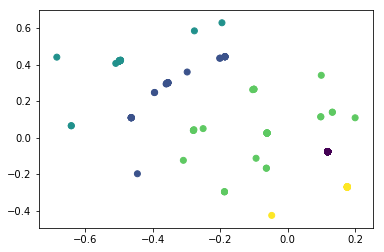

0    215
1     39
3     34
2     28
4     26
dtype: int64


In [4]:
# Test/Train status

# Need to compute DT104 split that has roughly the same amr resistant/susceptible proportions

# Separate into groups of broadly, moderately and not susceptible to all AM durgs.
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

X = dt104_df.as_matrix()

# MDS decomposition for visualization
D = pairwise_distances(X, metric='hamming')
mds =  MDS(n_components=2, random_state=3489, dissimilarity='precomputed', n_jobs=4)
D_mds2 = mds.fit_transform(D)
N = D_mds2.shape[0]

# Assign genomes to clonal groups/clusters based on pangenome distritribution
km = KMeans(n_clusters=5)
%time km.fit(D)
drug_clusters = km.labels_.tolist()

#fig = plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
#ax = Axes3D(fig)
colours = drug_clusters
plt.scatter(D_mds2[:, 0], D_mds2[:, 1], c=colours)

plt.show()

print(pd.Series(drug_clusters).value_counts())

from sklearn.model_selection import StratifiedShuffleSplit
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=3288)
train_index, test_index = next(spliter.split(X, drug_clusters))
tt_index = ['Training'] * X.shape[0]
tt_index = pd.Series(tt_index, index=dt104_df.index)
tt_index.ix[test_index] = 'Validation'

dataset_index = pd.Series(
    np.concatenate(
        (heidelburg_df['Dataset'], 
         kentucky_df['Dataset'],
         tt_index)), index=amr_df.index)

In [5]:
# Filter amr set
amr_list = list(amr_df.columns.values)

# Insufficient data
valid = ~np.apply_along_axis(lambda c: sum(c == 0) < 30 or sum(c == 1) < 30, 0, amr_df)
valid = valid.tolist()
amr_df = amr_df.loc[:,valid]
amr_list = np.array(amr_list)[valid]

# Correlated drugs
r = amr_df.corr()
x, y = np.where(r > .98)
nondiag = x != y
x = x[nondiag].tolist()
y = y[nondiag].tolist()

uppertri = dict()
for hc in zip(x,y):
    ind = '_'.join([str(i) for i in sorted(hc)])
    if not ind in  uppertri:
        print("Correlated Pair: {}:{}, {}:{} r: {}".format(hc[0], amr_list[hc[0]], hc[1], amr_list[hc[1]], r.ix[hc[0],hc[1]]))
    uppertri[ind] = True


# Keep only one correlated drug
removecols = [0,11]
keepcols = np.setdiff1d(np.arange(amr_df.shape[1]),removecols)
amr_df = amr_df.ix[:,keepcols]


Correlated Pair: 0:AMC, 3:CRO r: 0.988718414192881
Correlated Pair: 0:AMC, 9:TIO r: 0.9943570690186807
Correlated Pair: 3:CRO, 9:TIO r: 0.9943293460654471


In [6]:
# Load pangenome
panseq_file = '/media/poolhouse/workspace/l_amr/data/NML/salmonella_superset/panseq/percentIdentityCutoff90__fragmentationSize1000/pan_genome.txt'
pg, genome_index, locus_index = utils.read_panseq(panseq_file)

In [14]:
# Sync genome order between amr and pg matrices
if not len(np.setdiff1d(genome_index, amr_df.index)) == 0:
    raise Exception("Genome index mismatch")
    
genord = np.argsort(amr_df.index)
amr_df = amr_df.ix[genord,:]
dataset_index = dataset_index.loc[amr_df.index]
serovar_index = serovar_index.loc[amr_df.index]
pgord = np.argsort(genome_index)
pg = pg[pgord,:]
genome_index = genome_index[pgord]

In [18]:
# Save to file
from sklearn.externals import joblib
joblib.dump(amr_df, config.S['amr'])
joblib.dump(dataset_index, config.S['test_train_index'])
joblib.dump(serovar_index, config.S['serovar_index'])
joblib.dump(pg, config.S['pg'])
joblib.dump(locus_index, config.S['locus_index'])

['/media/poolhouse/workspace/l_amr/data/NML/salmonella_superset/ml/locus_index.jpkl']